### QOSF Screening Task Solution 

#### Name - Dighvijay Giri
#### Email ID - dighvijaygiri98@gmail dot com

Task choosen - Task 4

Find the lowest eigenvalue of the following matrix:

[1 0 0 0;
0 0 -1 0;
0 -1 0 0; 
0 0 0 1]

using VQE-like circuits, created by yourself from scratch.

In [1]:
import numpy as np 
from numpy import kron

from qiskit import QuantumCircuit, Aer, execute

### Function to decompose given matrix into sum of pauli matrices


In [2]:
def HS(M1, M2):
    #Hilbert-Schmidt-Product of two matrices M1, M2
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

def decompose(H):
    #Decompose Hermitian 4x4 matrix H into Pauli matrices
    
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    S = [id, sx, sy, sz]
    
    labels = ['I', 'X', 'Y', 'Z']
    for i in range(4):
        for j in range(4):
            label = labels[i] + labels[j]
            a_ij = 0.25 * HS(kron(S[i], S[j]), H)
            if a_ij != 0.0:
                print(a_ij,'*' ,label, '+')

In [3]:
H = np.array([[1, 0, 0, 0], [0, 0, -1, 0], [0, -1, 0, 0], [0, 0, 0, 1]])
decompose(H)

(0.5+0j) * II +
(-0.5+0j) * XX +
(-0.5+0j) * YY +
(0.5+0j) * ZZ +


### Preparing guess states (ansatz)

In [4]:
def prepare_ckt(angle):
    ckt = QuantumCircuit(2)
    ckt.h(0)
    ckt.cx(0, 1)
    ckt.rx(angle, 0)
    
    return ckt

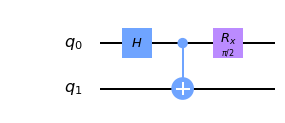

In [5]:
ckt = prepare_ckt(np.pi/2) #just an arbitrary angle for looking at the circuit
ckt.draw(output = 'mpl')

### Measuring Expectation Values

Starting with ZZ expectation value measurement. Creating a copy of the circuit and adding measurement elements to it.

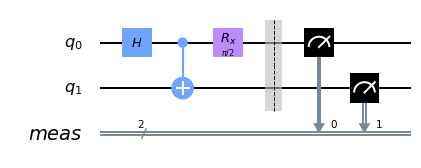

In [6]:
def measure_zz_circuit(ckt):
    zz_meas = ckt.copy()
    zz_meas.measure_all()
    return zz_meas

zz_meas = measure_zz_circuit(ckt)
zz_meas.draw(output ='mpl')

In [7]:
simulator = Aer.get_backend('qasm_simulator')

In [8]:
def measure_zz(ckt, num_shots = 10000):
    zz_meas = measure_zz_circuit(ckt)
    
    result = execute(zz_meas, backend = simulator, shots = num_shots).result()
    counts = result.get_counts(zz_meas)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    #signs obtained by applying zz to 00, 01, 01 and 11 states
    zz = counts['00'] + counts['11'] - counts['01'] - counts['10']  
    zz = zz / total_counts
    
    return zz

### To measure the expectation value of XX we need to add post rotations

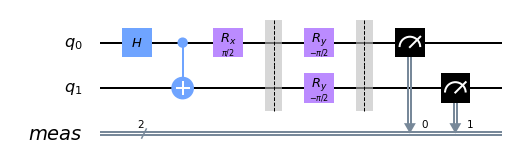

In [9]:
def measure_xx_circuit(ckt):
    xx_meas = ckt.copy()
    
    xx_meas.barrier()
    xx_meas.ry(-np.pi/2,0)
    xx_meas.ry(-np.pi/2,1)
    xx_meas.measure_all()
    
    return xx_meas

xx_meas = measure_xx_circuit(ckt)
xx_meas.draw(output='mpl')

In [10]:
def measure_xx(given_circuit, num_shots = 10000):
    
    xx_meas = measure_xx_circuit(given_circuit)
    
    result = execute(xx_meas, backend = simulator, shots = num_shots).result()
    counts = result.get_counts(xx_meas)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    xx = counts['00'] + counts['11'] - counts['01'] - counts['10']
    xx = xx / total_counts
    
    return xx

### Similarly, to measure the expectation value of YY we need to add post rotations

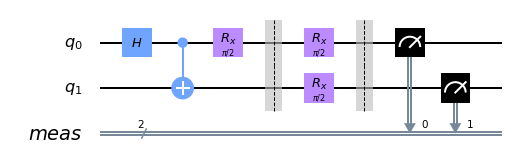

In [11]:
def measure_yy_circuit(ckt):
    yy_meas = ckt.copy()

    yy_meas.barrier()
    yy_meas.rx(np.pi/2, 0)
    yy_meas.rx(np.pi/2, 1)
    yy_meas.measure_all()
    
    return yy_meas

yy_meas = measure_yy_circuit(ckt)
yy_meas.draw(output='mpl')

In [12]:
def measure_yy(given_circuit, num_shots = 10000):
    
    yy_meas = measure_yy_circuit(given_circuit)
    
    result = execute(yy_meas, backend = simulator, shots = num_shots).result()
    counts = result.get_counts(yy_meas)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    yy = counts['00'] + counts['11'] - counts['01'] - counts['10']
    yy = yy / total_counts
    
    return yy

### Function to evaluate energy from the guess state

In [13]:
def get_energy(given_circuit, num_shots = 10000):
    
    zz = measure_zz(given_circuit, num_shots = num_shots)
    xx = measure_xx(given_circuit, num_shots = num_shots)
    yy = measure_yy(given_circuit, num_shots = num_shots)
    
    energy = 0.5*1 + (-0.5)*xx + (-0.5)*yy + 0.5*zz
    
    return energy

### Finding the lowest energy value

In [14]:
low_energy = 10000
for i in range(0, 361):
    ckt1 = prepare_ckt(i*np.pi/180)
    energy1 = get_energy(ckt1) 
    
    if (low_energy > energy1):
        low_energy = energy1
    #print(i, low_energy)

print(low_energy)

-1.0


In [15]:
w = np.linalg.eig(H)
print(w)

(array([ 1., -1.,  1.,  1.]), array([[ 0.        ,  0.        ,  1.        ,  0.        ],
       [-0.70710678,  0.70710678,  0.        ,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]))
